In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "-1" #使用cpu训练，0，1...表示GPU训练

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#config = tf.ConfigProto(allow_soft_placement = True)
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.33)
#config.gpu_options.allow_growth = True

In [2]:
#下载数据集
mnist = input_data.read_data_sets('MNIST_DATA',one_hot=True)

Extracting MNIST_DATA\train-images-idx3-ubyte.gz
Extracting MNIST_DATA\train-labels-idx1-ubyte.gz
Extracting MNIST_DATA\t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA\t10k-labels-idx1-ubyte.gz


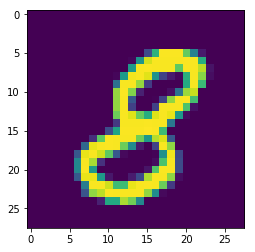

In [3]:
#显示一张训练图片
import matplotlib.pyplot as plt
image = mnist.train.images[5].reshape(28,28)
image = plt.imshow(image)
plt.show(image)

In [4]:
 mnist.train.images[5].reshape(-1,28,28,1).shape

(1, 28, 28, 1)

In [5]:
#输入图片是28*28
n_inputs = 28 #输入的序列为图片的一行数据，一行共28个数据
max_time = 28 #一张图片有28行，所以输入28行序列
lstm_size = 100 #隐层单元
n_classes = 10 #10个分类
batch_size = 50
n_batch = mnist.train.num_examples // batch_size

In [6]:
#创建两个占位符
#这里none表示第一个维度可以是任意的长度
x = tf.placeholder(tf.float32,[None,784])
y = tf.placeholder(tf.float32,[None,10])

In [7]:
#初始化权值
weights = tf.Variable(tf.truncated_normal([lstm_size,n_classes],stddev=0.1))
#初始化偏置值
biases = tf.Variable(tf.constant(0.1,shape = [n_classes]))

In [8]:
#定义RNN网络
def RNN(X,weights,biases):
    #inputs = [batch_size,max_time,n_inputs]
    inputs = tf.reshape(X,[-1,max_time,n_inputs])#-1就表示batch_size
    #定义LSTM基本cell
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    #final_state[0]是cell_state
    #final_state[1]是hidden_state
    with tf.variable_scope('rnn'):
        outputs,final_state = tf.nn.dynamic_rnn(lstm_cell,inputs,dtype=tf.float32,scope='rnn')
        results = tf.nn.softmax(tf.matmul(final_state[1],weights) + biases)
    
    return results

In [9]:
prediction = RNN(x,weights,biases)#计算RNN返回结果

In [10]:
#损失函数
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=prediction))

In [11]:
#使用AdamOptimizer进行优化
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
#结果存放在一个布尔型列表中,argmax返回一维张量中最大值所在的位置
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(prediction,1))
#求准确率
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
#初始化变量
init = tf.global_variables_initializer()

In [12]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(6):
        for batch in range(n_batch):
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            sess.run(train_step,feed_dict={x:batch_xs,y:batch_ys})
        acc = sess.run(accuracy,feed_dict={x:mnist.test.images,y:mnist.test.labels})
        print('Iter'+str(epoch)+',Testing acc'+str(acc))
        
        #保存模型
        saver.save(sess,'net/my_net.ckpt')

Iter0,Testing acc0.7935
Iter1,Testing acc0.87
Iter2,Testing acc0.9022
Iter3,Testing acc0.9161
Iter4,Testing acc0.9188
Iter5,Testing acc0.9314


In [12]:
#使用保存的模型
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(accuracy,feed_dict={x:mnist.test.images,y:mnist.test.labels}))
    saver.restore(sess,'net/my_net.ckpt')
    print(sess.run(accuracy,feed_dict={x:mnist.test.images,y:mnist.test.labels}))

0.0867
INFO:tensorflow:Restoring parameters from net/my_net.ckpt
0.9314
